In [2]:
import numpy as np
import pandas as pd
import keras
from keras import regularizers, optimizers
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, SpatialDropout1D, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing.data import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
dataset_loc = 'dataset/dataset/ydata-ysm-keyphrase-bid-imp-click-v1_0.gz'

df = pd.read_csv(dataset_loc, sep='\t', nrows=100000, names=['day', 'anon_accountID', 'rank', 'anon_keyphrase', 'avg_bid', 'impressions', 'clicks'])

df = df.sort_values(by='day')

In [4]:
df.head()

,day,anon_accountID,rank,anon_keyphrase,avg_bid,impressions,clicks
0,1,08bade48-1081-488f-b459-6c75d75312ae,2,2affa525151b6c51 79021a2e2c836c1a 327e089362aa...,100.0,2.0,0.0
12151,1,bcbad0a2-c502-44ba-9e8a-16ade955ece5,6,de84da9dfd5a336d 260ab222e6f66963,500.0,1.0,0.0
12157,1,bcbad0a2-c502-44ba-9e8a-16ade955ece5,1,de84da9dfd5a336d 9a914980640c1af3 569e9b84e86b...,500.0,1.0,0.0
12162,1,bcbad0a2-c502-44ba-9e8a-16ade955ece5,1,de84da9dfd5a336d 6f4a4738acf270b7 f43586ba2ab3...,560.0,1.0,0.0
12175,1,bcbad0a2-c502-44ba-9e8a-16ade955ece5,10,de84da9dfd5a336d ef8c02936aa620f8 50672b71ad8f...,510.0,1.0,0.0


In [5]:
anon_id = LabelEncoder()
anon_keyphrases = LabelEncoder()

anon_id.fit(df['anon_accountID'])
df['anon_accountID'] = anon_id.transform(df['anon_accountID'])

anon_id.fit(df['anon_keyphrase'])
df['anon_keyphrase'] = anon_id.transform(df['anon_keyphrase'])


In [6]:
df['clicks'] = StandardScaler().fit_transform(df['clicks'].values.reshape(-1, 1))
df['avg_bid'] = StandardScaler().fit_transform(df['avg_bid'].values.reshape(-1, 1))

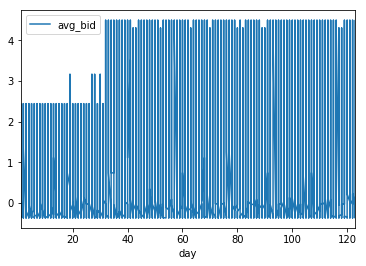

In [16]:
df2 = df[ (df.avg_bid < 20)]
df2.plot(x='day', y='avg_bid')

In [18]:
training_points = 2000
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps
n_steps = 64
n_features =4
n_steps_out =1
# split into samples
rawsequence = np.array(df[['anon_accountID', 'avg_bid', 'impressions', 'clicks']].values)
#rawsequence = np.array(df['scaled_value'])
trainsequence = rawsequence[0:training_points]
testsequence = rawsequence[training_points:]

X_train, y_train = split_sequence(trainsequence, n_steps, n_steps_out)
X_test, y_test = split_sequence(testsequence, n_steps, n_steps_out)
# summarize the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

#print(rawsequence[0:12])
for i in range(2):
	print(X_train[i][0:4], y_train[i])

(1936, 64, 4) (1936, 1, 4)
(97936, 64, 4) (97936, 1, 4)
[[ 1.00000000e+00 -3.63721257e-01  2.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01 -4.73970575e-02  1.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01 -4.73970575e-02  1.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01  5.15724308e-05  1.00000000e+00 -5.67196833e-02]] [[40.         -0.04739706  2.         -0.05671968]]
[[ 4.00000000e+01 -4.73970575e-02  1.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01 -4.73970575e-02  1.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01  5.15724308e-05  1.00000000e+00 -5.67196833e-02]
 [ 4.00000000e+01 -3.94889525e-02  1.00000000e+00 -5.67196833e-02]] [[21.         -0.16601863  3.         -0.05671968]]


In [19]:
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(X_train.shape)

(1936, 64, 4)
(1936, 64, 4)


In [20]:
print(y_train.shape)
#y_train = y_train.reshape(y_train.shape[0],y_train.shape[1],n_features)
y_train = y_train.reshape(y_train.shape[0],n_features)
print(y_train.shape)

(1936, 1, 4)
(1936, 4)


In [21]:
from keras.layers import regularizers, Flatten

input_layer = Input (shape = (n_steps, n_features))
conv_1 = Conv1D(filters=256, kernel_size=1, dilation_rate=1,
                padding='causal', strides=1,input_shape=(n_steps, n_features),
                kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(input_layer)

drop_1 = SpatialDropout1D(0.3)(conv_1)

conv_2 = Conv1D(filters=128, kernel_size=1, dilation_rate=1,
                padding='causal',strides=1, kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_1)

drop_2 = SpatialDropout1D(0.3)(conv_2)

conv_3 = Conv1D(filters=64, kernel_size=1, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.01),
                activation='relu')(drop_2)

drop_3 = SpatialDropout1D(0.3)(conv_3)

conv_4 = Conv1D(filters=32, kernel_size=1, dilation_rate=1,
                padding='causal', strides=1,kernel_regularizer=regularizers.l2(0.05),
                activation='relu')(drop_3)

flattened = Flatten()(conv_4)
dense = Dense(32)(flattened)
out = Dense(4)(dense)

model = Model(input_layer, out)
model.compile(optimizer=keras.optimizers.Adam(lr=0.002), loss='mse', metrics=['mse', 'accuracy'])
print(model.summary())

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 4)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 256)           1280      
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 64, 128)           32896     
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 64, 128)           0         
_______________________________________________________

In [23]:
batch_size=32
epochs=200

model.fit(x=X_train, y=y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=1)

Epoch 1/200
1936/1936 [==============================] - 8s - loss: 108.1422 - mean_squared_error: 103.8100 - acc: 0.9421     
Epoch 2/200
1936/1936 [==============================] - 0s - loss: 99.3454 - mean_squared_error: 95.3928 - acc: 0.9571      
Epoch 3/200
1936/1936 [==============================] - 0s - loss: 98.0690 - mean_squared_error: 94.3157 - acc: 0.9566      
Epoch 4/200
1936/1936 [==============================] - 0s - loss: 97.5582 - mean_squared_error: 93.9799 - acc: 0.9571      
Epoch 5/200
1936/1936 [==============================] - 0s - loss: 94.5550 - mean_squared_error: 91.1286 - acc: 0.9571     
Epoch 6/200
1936/1936 [==============================] - 0s - loss: 94.0690 - mean_squared_error: 90.7832 - acc: 0.9571     
Epoch 7/200
1936/1936 [==============================] - 0s - loss: 93.5915 - mean_squared_error: 90.4341 - acc: 0.9561     
Epoch 8/200
1936/1936 [==============================] - 0s - loss: 94.2485 - mean_squared_error: 91.2108 - acc: 0.9561 

1936/1936 [==============================] - 0s - loss: 80.4360 - mean_squared_error: 79.2204 - acc: 0.9530     
Epoch 67/200
1936/1936 [==============================] - 0s - loss: 81.8428 - mean_squared_error: 80.6253 - acc: 0.9525     
Epoch 68/200
1936/1936 [==============================] - 0s - loss: 81.1478 - mean_squared_error: 79.9409 - acc: 0.9545     
Epoch 69/200
1936/1936 [==============================] - 0s - loss: 80.7686 - mean_squared_error: 79.5504 - acc: 0.9483     
Epoch 70/200
1936/1936 [==============================] - 0s - loss: 79.8372 - mean_squared_error: 78.6091 - acc: 0.9535     
Epoch 71/200
1936/1936 [==============================] - 0s - loss: 80.7613 - mean_squared_error: 79.5278 - acc: 0.9483     
Epoch 72/200
1936/1936 [==============================] - 0s - loss: 79.7155 - mean_squared_error: 78.4852 - acc: 0.9587     
Epoch 73/200
1936/1936 [==============================] - 0s - loss: 78.8047 - mean_squared_error: 77.5714 - acc: 0.9525     
Epoch

1936/1936 [==============================] - 0s - loss: 76.9783 - mean_squared_error: 75.3731 - acc: 0.9432     
Epoch 130/200
1936/1936 [==============================] - 0s - loss: 77.1059 - mean_squared_error: 75.4794 - acc: 0.9504     
Epoch 131/200
1936/1936 [==============================] - 0s - loss: 74.2152 - mean_squared_error: 72.5730 - acc: 0.9447     
Epoch 132/200
1936/1936 [==============================] - 0s - loss: 73.1643 - mean_squared_error: 71.5087 - acc: 0.9458     
Epoch 133/200
1936/1936 [==============================] - 0s - loss: 73.0169 - mean_squared_error: 71.3538 - acc: 0.9411     
Epoch 134/200
1936/1936 [==============================] - 0s - loss: 74.6064 - mean_squared_error: 72.9463 - acc: 0.9463     
Epoch 135/200
1936/1936 [==============================] - 0s - loss: 73.1049 - mean_squared_error: 71.4195 - acc: 0.9411     
Epoch 136/200
1936/1936 [==============================] - 0s - loss: 74.3493 - mean_squared_error: 72.6369 - acc: 0.9447    

1936/1936 [==============================] - 0s - loss: 72.1016 - mean_squared_error: 69.8885 - acc: 0.9427     
Epoch 193/200
1936/1936 [==============================] - 0s - loss: 75.4905 - mean_squared_error: 73.2569 - acc: 0.9401     
Epoch 194/200
1936/1936 [==============================] - 0s - loss: 71.8753 - mean_squared_error: 69.6471 - acc: 0.9365     
Epoch 195/200
1936/1936 [==============================] - 0s - loss: 73.2470 - mean_squared_error: 71.0157 - acc: 0.9411     
Epoch 196/200
1936/1936 [==============================] - 0s - loss: 69.3020 - mean_squared_error: 67.0582 - acc: 0.9380     
Epoch 197/200
1936/1936 [==============================] - 0s - loss: 69.3502 - mean_squared_error: 67.0963 - acc: 0.9411     
Epoch 198/200
1936/1936 [==============================] - 0s - loss: 70.9778 - mean_squared_error: 68.7303 - acc: 0.9360     
Epoch 199/200
1936/1936 [==============================] - 0s - loss: 72.9425 - mean_squared_error: 70.6906 - acc: 0.9463    

In [24]:
test1 = testsequence[:n_steps]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
print(test1.shape)
test1_pred = model.predict(x=test1)
print(testsequence[n_steps-2:n_steps+2])
print(test1_pred)

test1 = testsequence[128:n_steps+128]
print(test1.shape)
test1.shape = (1, n_steps, n_features)
test1_pred = model.predict(x=test1)
print(testsequence[128+n_steps-2:128+n_steps+2])
print(test1_pred)

(64, 4)
(1, 64, 4)
[[30.          0.39545682  2.         -0.05671968]
 [39.          0.74341344  1.         -0.05671968]
 [14.         -0.32418073  1.         -0.05671968]
 [14.         -0.32418073  1.         -0.05671968]]
[[23.21909     0.22558743 -4.338247   -0.12333544]]
(64, 4)
[[14.         -0.17392674  1.         -0.05671968]
 [40.         -0.04739706  1.         -0.05671968]
 [14.         -0.32418073  1.         -0.05671968]
 [14.         -0.31627263  2.         -0.05671968]]
[[23.40574     0.46621737  2.9925811   0.03636099]]


In [25]:
y_pred = model.predict(x=X_test)
y_pred

array([[23.219088  ,  0.22558847, -4.3382473 , -0.12333556],
       [22.559896  ,  0.04948702,  7.6385403 ,  0.04961424],
       [21.546892  ,  0.17608061,  1.665336  , -0.08654995],
       ...,
       [13.299914  , -0.20339271, -4.3585844 , -0.39106745],
       [29.021019  ,  0.34954777, -8.505351  ,  0.05144243],
       [23.504202  , -0.19306716, 13.864982  ,  0.30872566]],
      dtype=float32)

In [26]:
y_test.shape = (y_test.shape[0], n_features)
y_test.shape

(97936, 4)

In [29]:
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 69.640


In [30]:

#testing_dataset = sequence
print("testing_dataset: ", y_test.shape)
print("testing_pred: ", y_pred.shape)

print(y_test[128:130:])
print(y_pred[128:130])
errors = y_test - y_pred
print(errors.shape)
print(errors[128:130])

rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)

testing_dataset:  (97936, 4)
testing_pred:  (97936, 4)
[[14.         -0.32418073  1.         -0.05671968]
 [14.         -0.31627263  2.         -0.05671968]]
[[23.40574     0.46621624  2.9925818   0.03636007]
 [ 1.3163145  -0.596959   -0.6388699   0.09897815]]
(97936, 4)
[[-9.40574074 -0.79039697 -1.99258184 -0.09307976]
 [12.68368554  0.28068637  2.63886988 -0.15569783]]
Test RMSE: 69.640


Int64Index([ 2000, 80293, 80294, 92410, 37934, 45072, 13302, 17273, 44950,
            31267,
            ...
             1862, 59731, 20768, 20771, 20776, 93880, 65315, 65300, 29576,
            66573],
           dtype='int64', length=26703)
(97936, 4)
    eclicks
0  0.066616
1  0.106334
2  0.029830
3  0.158960
4  0.144972
RangeIndex(start=0, stop=97936, step=1)
       day  anon_accountID   avg_bid  impressions   clicks
2000    89              30 -0.015765          8.0 -0.05672
80293   89              14 -0.363721          2.0 -0.05672
80294   89              14 -0.363721          1.0 -0.05672
92410   89              14 -0.221375          4.0 -0.05672
37934   89              13 -0.173927          1.0 -0.05672
(26703, 5)
(97936, 6)
    day  anon_accountID   avg_bid  impressions   clicks   eclicks
0  89.0            30.0 -0.015765          8.0 -0.05672  0.066616
1  89.0            14.0 -0.363721          2.0 -0.05672  0.106334
2  89.0            14.0 -0.363721          1.0 -0.05672  0

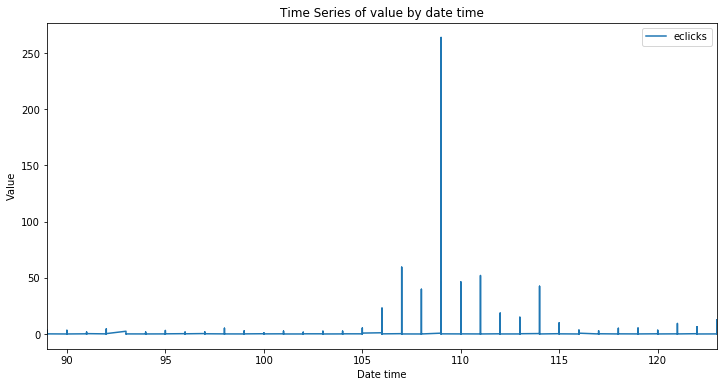

In [40]:
df2 = df.copy()
df2 = df2.loc[training_points:]
df2 = df2[['day','anon_accountID', 'avg_bid', 'impressions', 'clicks']]
print(df2.index)

errorsDF = pd.DataFrame(errors, columns=['eaccID','ebid','eimpressions','eclicks'])
#errorsDF = pd.DataFrame(errors, columns=['a'])
print(errorsDF.shape)
errorsDF = errorsDF[['eclicks']]
errorsDF['eclicks'] = errorsDF['eclicks'].abs()
#errorsDF['predval']=scaler.inverse_transform(pd.DataFrame(errorsDF['predval']))
print(errorsDF.head(5))
print(errorsDF.index)

print(df2.head(5))
print(df2.shape)

df2.reset_index(drop=True, inplace=True)
errorsDF.reset_index(drop=True, inplace=True)

dfModified = pd.concat([df2, errorsDF], axis=1)
print(dfModified.shape)
print(dfModified.head(5))
dfModified.plot(x='day', y='eclicks', figsize=(12,6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

df2 = dfModified[(dfModified.day >= 0) & (dfModified.day <=20)]
df2 = df2.reset_index(drop=True)
print(df2.head(5))

In [45]:
y_testDF = pd.DataFrame(y_test, columns=['anon_accountID','o_avg_bid','oimpressions','oclicks'])
y_predDF = pd.DataFrame(y_pred, columns=['anon_accountID','p_avg_bid','pimpressions','pclicks'])
y_testDF = y_testDF[['oclicks']]
y_predDF = y_predDF[['pclicks']]
# 'avg_bid', 'impressions', 'clicks'
#y_testDF['origval']=scaler.inverse_transform(pd.DataFrame(y_testDF['origval']))
#y_predDF['predval']=scaler.inverse_transform(pd.DataFrame(y_predDF['predval']))
print(y_testDF.head(5))
print(y_predDF.head(5))

   oclicks
0 -0.05672
1 -0.05672
2 -0.05672
3 -0.05672
4 -0.05672
    pclicks
0 -0.123336
1  0.049614
2 -0.086550
3  0.102240
4  0.088252


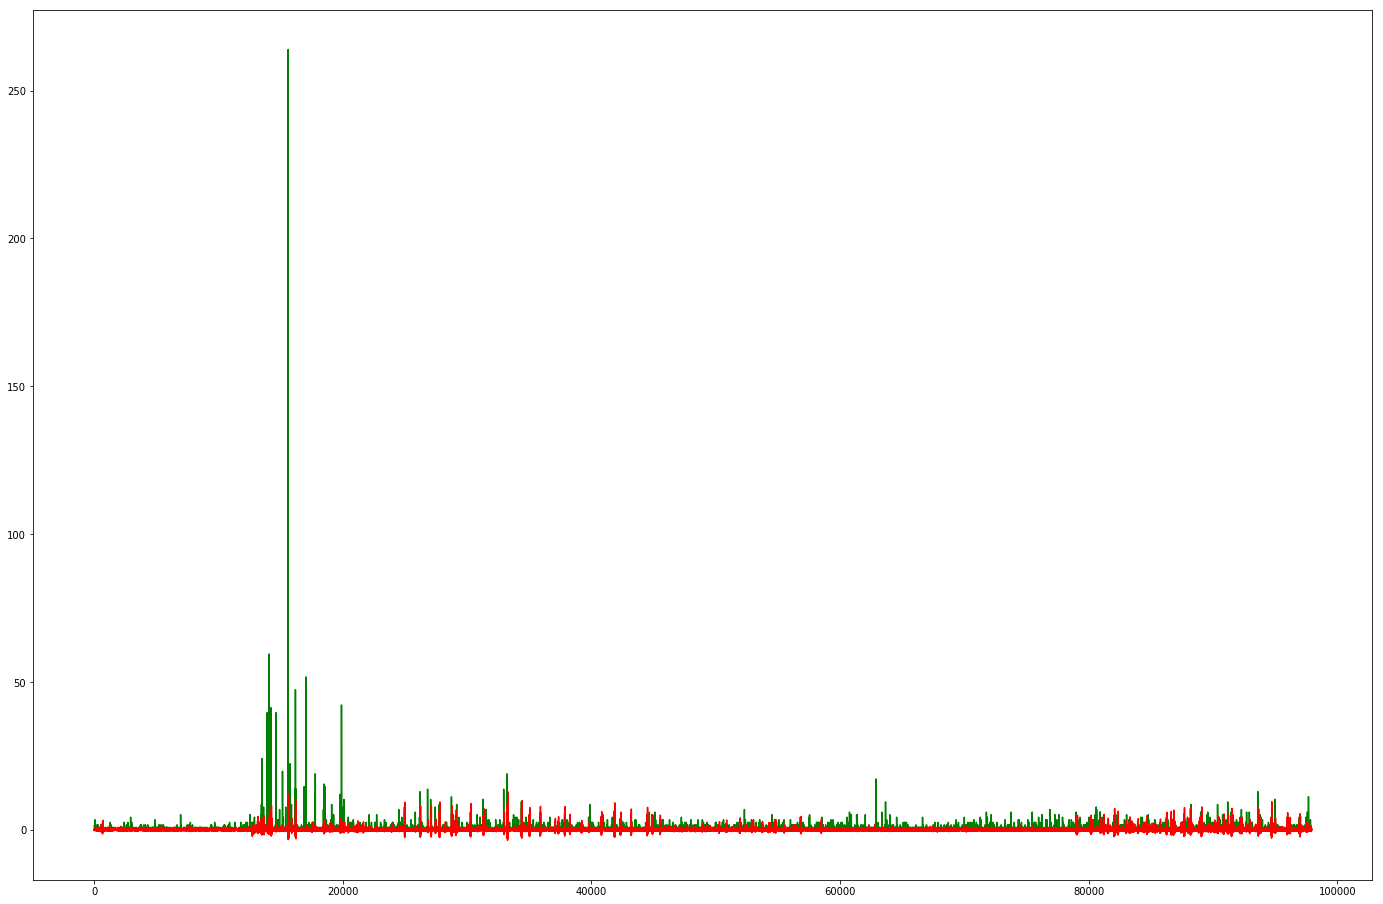

In [46]:
plt.figure(figsize=(24,16))
plt.plot(y_testDF, color='green')
plt.plot(y_predDF, color='red')

In [47]:
#based on cutoff after sorting errors
dist = np.linalg.norm(y_testDF - y_predDF, axis=-1)

scores =dist.copy()
print(scores.shape)
scores.sort()
cutoff = int(0.995 * len(scores))
print(cutoff)
print(scores[cutoff:])
threshold= scores[cutoff]


(97936,)
97446
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

In [48]:
#label the records anomalies or not based on threshold
z = zip(dist >= threshold, dist)

y_label=np.zeros(df.shape[0])
error = np.zeros(df.shape[0])
i=training_points+n_steps
print(i)
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label[i] = 1
    error[i] = dist
    i = i + 1
print(len(y_label))
print(len(error))

2064
100000
100000


C:\Users\Shumpu\Anaconda2\envs\p36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


In [49]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            x = group.index.values
            y = group.error
            axes.plot(x, y, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
        plt.figure(figsize=(10, 8))
        plt.plot(error, marker='o', ms=3.5, linestyle='',
                 label='Point')

        plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="r", zorder=100, label='Threshold')
        plt.legend()
        plt.title("Reconstruction error")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

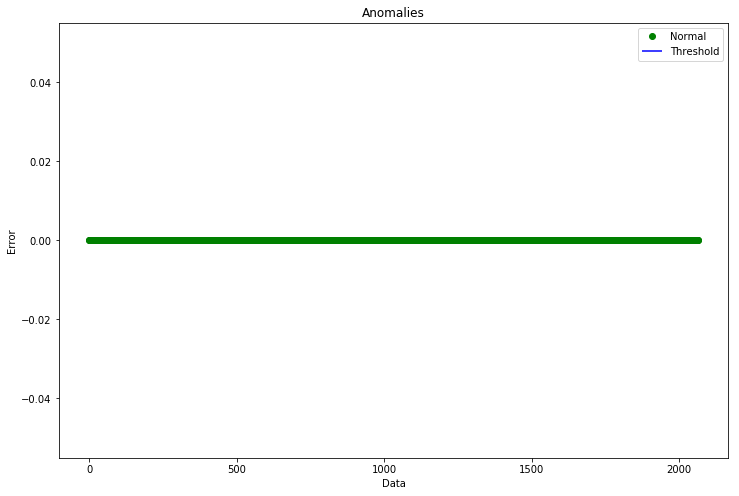

In [50]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [54]:
print(df.shape)
print(len(y_label))
adf = pd.DataFrame({'day': df['day'], 'clicks': df['clicks'],
                    'error': error, 'anomaly': y_label})
adf.head(5)


(100000, 7)
100000


,day,clicks,error,anomaly
0,1,-0.05672,0.0,0.0
12151,1,-0.05672,0.0,0.0
12157,1,-0.05672,0.0,0.0
12162,1,-0.05672,0.0,0.0
12175,1,-0.05672,0.0,0.0


Text(0.5,1,'Time Series of value by date time')

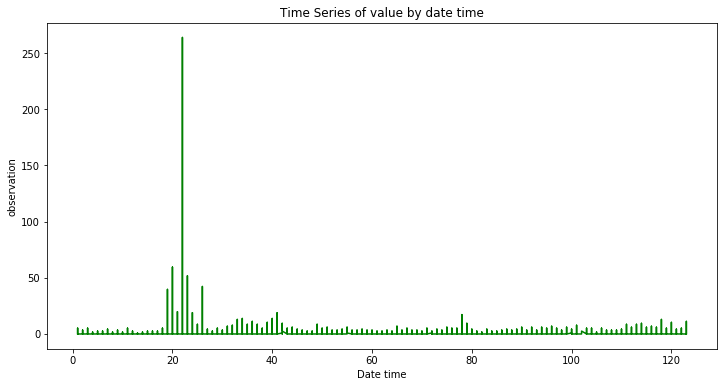

In [55]:
figure, axes = plt.subplots(figsize=(12, 6))
axes.plot(adf['day'], adf['clicks'], color='g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['day'].values, anomaliesDF['clicks'], color='r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')